<a href="https://colab.research.google.com/github/probml/ssm-jax/blob/main/ssm_jax/hmm/demos/gaussian_hmm_2d_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import optax
except ModuleNotFoundError:
    %pip install optax
    import optax

In [2]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax 

In [3]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit, value_and_grad

import optax

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm.auto import trange

from ssm_jax.hmm.models import GaussianHMM

In [4]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging
logger = logging.getLogger() 

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# Helper functions for plotting

In [5]:
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "clay",
    "pink",
    "greyish",
    "mint",
    "light cyan",
    "steel blue",
    "forest green",
    "pastel purple",
    "salmon",
    "dark brown"]

colors = sns.xkcd_palette(color_names)

def white_to_color_cmap(color, nsteps=256):
    """Return a cmap which ranges from white to the specified color.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    # Get a red-white-black cmap
    cdict = {'red': ((0.0, 1.0, 1.0),
                       (1.0, color[0], color[0])),
                'green': ((0.0, 1.0, 1.0),
                          (1.0, color[1], color[0])),
                'blue': ((0.0, 1.0, 1.0),
                         (1.0, color[2], color[0]))}
    cmap = LinearSegmentedColormap('white_color_colormap', cdict, nsteps)
    return cmap


def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0,1,ncolors)


    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

cmap = gradient_cmap(colors)

# Construct an HMM with specific parameters

In [6]:
# Set dimensions
num_states = 5
emission_dim = 2

# Specify parameters of the HMM
initial_probs = jnp.ones(num_states) / num_states
transition_matrix = 0.95 * jnp.eye(num_states) + 0.05 * jnp.roll(jnp.eye(num_states), 1, axis=1)
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, num_states+1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, num_states+1))[:-1]
])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (num_states, 1, 1))

# Make a true HMM
true_hmm = GaussianHMM(initial_probs,
                       transition_matrix,
                       emission_means, 
                       emission_covs)

# Sample states and emissions from the HMM

In [7]:
num_timesteps = 2000
true_states, emissions = true_hmm.sample(jr.PRNGKey(0), num_timesteps)

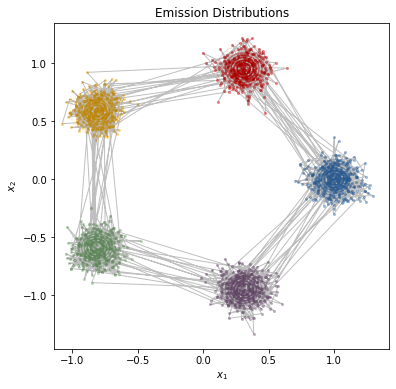

In [8]:
def plot_gaussian_hmm(hmm, emissions, states):
    lim = .85 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), 
                          jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    lls = hmm.emission_distribution.log_prob(grid[:, None, :])
    plt.figure(figsize=(6, 6))
    for k in range(hmm.num_states):
        plt.contour(XX, YY, jnp.exp(lls[:,k]).reshape(XX.shape), 
                    cmap=white_to_color_cmap(colors[k]))
        plt.plot(emissions[states==k, 0], 
                 emissions[states==k, 1], 
                 'o', mfc=colors[k], mec='none', ms=3, 
                 alpha=.5)

    plt.plot(emissions[:,0], emissions[:,1], '-k', lw=1, alpha=.25)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Emission Distributions")
    
plot_gaussian_hmm(true_hmm, emissions, true_states)

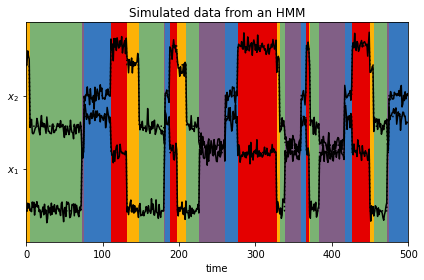

In [9]:
def plot_gaussian_hmm_emissions(hmm, emissions, states, xlim=None):
    # Plot the data and the smoothed data
    lim = 1.05 * abs(emissions).max()
    plt.imshow(states[None,:],
               aspect="auto",
               interpolation="none",
               cmap=cmap,
               vmin=0, vmax=len(colors)-1,
               extent=(0, num_timesteps, -lim, (emission_dim)*lim),
               alpha=1)

    means = true_hmm.emission_means[states]
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')
        plt.plot(means[:,d] + lim * d, ':k')

    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)
        
    plt.xlabel("time")
    plt.yticks(lim * jnp.arange(emission_dim), ["$x_{}$".format(d+1) for d in range(emission_dim)])
    
    plt.title("Simulated data from an HMM")
    plt.tight_layout()
    
plot_gaussian_hmm_emissions(true_hmm, emissions, true_states, xlim=(0, 500))

In [10]:
print("log joint prob:    ", true_hmm.log_prob(true_states, emissions))
print("log marginal prob: ", true_hmm.marginal_log_prob(emissions))

log joint prob:     3149.1013
log marginal prob:  3149.1047


# Fit with EM

In [11]:
# Quick test: 2 iterations

import ssm_jax.hmm.learning as learning

# Initialize a random GaussianHMM with twice number of true states
test_hmm_em = GaussianHMM.random_initialization(jr.PRNGKey(1), 2 * num_states, emission_dim)

test_hmm_em, logprobs_em = learning.hmm_fit_em(test_hmm_em, emissions, niter=2)

print(logprobs_em)
mu = test_hmm_em.emission_distribution.mean()
print(mu.shape)
print(mu)

  0%|          | 0/2 [00:00<?, ?it/s]

[DeviceArray(-5752.9707, dtype=float32), DeviceArray(-3600.2395, dtype=float32)]
(10, 2)
[[-0.7128358   0.34003398]
 [ 0.5512284   0.44861594]
 [-0.69198537 -0.24095066]
 [ 0.5759436   0.10193641]
 [ 0.60077226 -0.41451645]
 [ 0.58633214 -0.5504085 ]
 [-0.8054602   0.04864644]
 [-0.6511181   0.02404097]
 [-0.38475785 -0.5139994 ]
 [-0.71649766  0.05245874]]


  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'Marginal log likelihood')

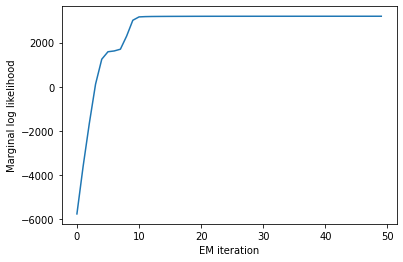

In [12]:
# Initialize a random GaussianHMM with twice number of true states
test_hmm_em = GaussianHMM.random_initialization(jr.PRNGKey(1), 2 * num_states, emission_dim)

# Longer training
test_hmm_em, logprobs_em = learning.hmm_fit_em(test_hmm_em, emissions, niter=50)


plt.plot(logprobs_em)
plt.xlabel("EM iteration")
plt.ylabel("Marginal log likelihood")

In [13]:
test_hmm = test_hmm_em

print("true LL: ", true_hmm.marginal_log_prob(emissions))
print("EM LL:  ", test_hmm.marginal_log_prob(emissions))

true LL:  3149.1047
EM LL:   3187.979


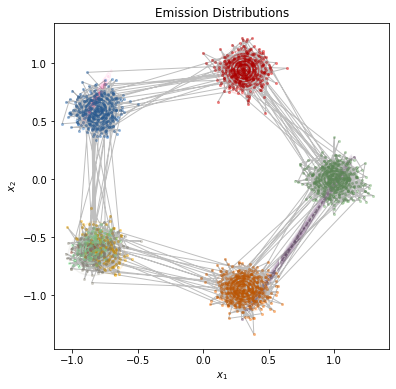

In [14]:
most_likely_states = test_hmm.most_likely_states(emissions)
plot_gaussian_hmm(test_hmm, emissions, most_likely_states)

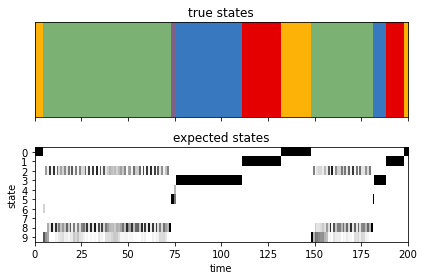

In [15]:
posterior = test_hmm.smoother(emissions)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states[None,:],
              aspect="auto",
              interpolation="none",
              cmap=cmap, 
              vmin=0, vmax=len(colors)-1,
              alpha=1)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(posterior.smoothed_probs.T,
              aspect="auto",
              interpolation="none",
              cmap="Greys",
              vmin=0, vmax=1)
axs[1].set_yticks(jnp.arange(test_hmm.num_states))
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("expected states")

plt.xlim(0, 200)
plt.tight_layout()

# Fit with SGD

In [16]:
# Quick test 
test_hmm_sgd = GaussianHMM.random_initialization(jr.PRNGKey(1), 2 * true_hmm.num_states, true_hmm.num_obs)

optimizer = optax.adam(learning_rate=1e-2)

test_hmm_sgd, losses = learning.hmm_fit_sgd(GaussianHMM, test_hmm_sgd, emissions, optimizer, niter=2)

print(losses)

  0%|          | 0/2 [00:00<?, ?it/s]

[DeviceArray(2.8764856, dtype=float32), DeviceArray(2.8524058, dtype=float32)]


In [17]:

mu = test_hmm_sgd.emission_distribution.mean()
print(mu.shape)
print(mu)

(10, 2)
[[-1.8273785   0.5582408 ]
 [ 0.60391396  0.77370846]
 [-1.7359222  -0.3046213 ]
 [-0.504322    1.1209666 ]
 [ 0.6116005  -0.64140046]
 [ 0.75580865  0.02256131]
 [-3.1687376   0.37064213]
 [-0.6466282   0.53755367]
 [-1.1433808  -0.51241666]
 [-0.52626145  0.45167205]]


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

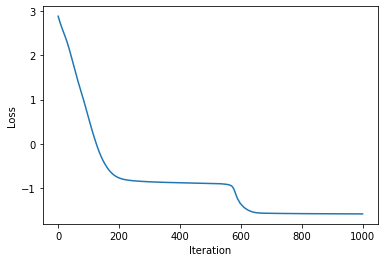

In [18]:

# Longer run

test_hmm_sgd = GaussianHMM.random_initialization(jr.PRNGKey(1), 2 * true_hmm.num_states, true_hmm.num_obs)

optimizer = optax.adam(learning_rate=1e-2)

test_hmm_sgd, losses = learning.hmm_fit_sgd(GaussianHMM, test_hmm_sgd, emissions, optimizer, niter=1000)

# Plot the training curve
losses = jnp.stack(losses)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")

true LL:  3149.1047
SGD LL:   3144.2239


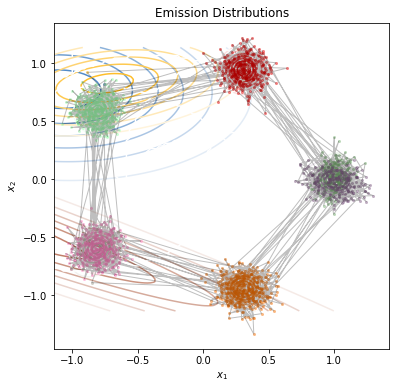

In [19]:
# Reconstruct the HMM
test_hmm = test_hmm_sgd
print("true LL: ", true_hmm.marginal_log_prob(emissions))
print("SGD LL:  ", test_hmm.marginal_log_prob(emissions))

# Get the most likely states and plot them
most_likely_states = test_hmm.most_likely_states(emissions)
plot_gaussian_hmm(test_hmm, emissions, most_likely_states)

We see that SGD found a worse (smaller LL) solution than EM.